<a href="https://colab.research.google.com/github/gsilver321/project_chd/blob/main/project2_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 CHD Paper
### DS 3001: Foundations of Machine Learning
### Gabe Silverstein, Rohan Chowla, Evan Stewart, and Rithwik Raman

## Summary

>  This research project aimed to develop a predictive model for Coronary Heart Disease (CHD) utilizing data from the Framingham Heart Study. To develop this model, the group first posed its research question: how can we utilize various conditions and risk factors to construct a reliable model that accurately forecasts whether someone is at risk for CHD in ten years? We then scanned the dataset which included a diverse range of factors such as age, smoking status (current smoker or not), number of cigarettes smoked per day, presence of diabetes, and body mass index (BMI). With the research question formulated and the dataset determined, the methodology needed to address this question was developed. The group initially researched which types of models work well in this scenario and determined that classifiers would work well. We then settled on using an iterative approach to test different classifiers and hyperparameters until finally picking a decision tree algorithm to build the predictive model. While this approach may not be the most efficient, it was easy to implement and worked pretty well in this scenario.
When setting up our decision tree, we did some searching to find some of the most highly correlated subsets of variables to determine feature importance. These searches were performed on cleaned data that had been imputed and winsorized. We found the five most important variables to be: `sysBP` (systolic blood pressure), `glucose`, `totChol` (total cholesterol), `age`, and `cigsPerDay` (self-reported number of average cigarettes consumed per day). Once the variables were determined, the train data was oversampled to ensure that there is an equal number of participants with risk of heart disease and those without for the model to be trained on. The decision tree model created with these parameters and train data performed pretty well, as indicated by an area under the curve (AUC) value of approximately 0.65.
Through incorporating a comprehensive set of risk factors and iteratively tuning the hyperparameters, the decision tree demonstrated good effectiveness in accurately predicting the risk of ten-year CHD. The relatively high AUC value suggests that the model's ability to distinguish between individuals who are at risk and those who aren’t is better than random chance. Although the group faced challenges in developing the model, we were able to create a pretty successful strategy to answer our research question. Using, `sysBP`, `glucose`, `totChol`, `age`, and `cigsPerDay`, we constructed a reliable model that did better than random chance at forecasting the ten-year risk of CHD.






## Data Analysis



> For this data analysis, the group pulled variables from the provided Framingham Heart Study on Coronary Heart Disease which has been running since 1948 and is now on its third generation of participants. The variables from the dataset include:

>```
sex: the recorded sex of the participant with 1 denoting a participant coded as male and 0 denoting a participant coded as female
age : Age at the time of medical examination in years.
education: A categorical variable of the participants education, with the levels: Some high school (1), high school/GED (2), some college/vocational school (3), college (4)
currentSmoker: Current cigarette smoking at the time of examinations
cigsPerDay: Number of cigarettes smoked each day
BPmeds: Use of Anti-hypertensive medication at exam
prevalentStroke: Prevalent Stroke (0 = free of disease)
prevalentHyp: Prevalent Hypertensive. Subject was defined as hypertensive if treated
diabetes: Diabetic according to criteria of first exam treated
totChol: Total cholesterol (mg/dL)
sysBP: Systolic Blood Pressure (mmHg)
diaBP: Diastolic blood pressure (mmHg)
BMI: Body Mass Index, weight (kg)/height (m)^2
heartRate: Heart rate (beats/minute)
glucose: Blood glucose level (mg/dL)
TenYearCHD : The 10 year risk of coronary heart disease (CHD)

> Although this dataset had many potential variables for the predictive model, the group did not have trouble reading in the dataset. The files weren't too large and had already been split up into train and test data. Additionally, all of the categorical variables (e.g. sex, education, etc.) had already been integer encoded which made comparing variables much easier later on.

> Despite the data being formatted pretty nicely, the group still had some challenges cleaning the data and preparing it for the predictive model. Specifically, we had to deal with outliers. In order to ensure that the model had an easier time at predicting the risk of ten-year heart disease, we winsorized all of the continuous variables and brought the outliers within the whiskers of the boxplot distribution. After ommitting most outliers, we needed to fix null and missing values. For the train data, these missings were counted at 85, 24, 37, 39, 15, and 285 for education, `cigsPerDay`, `BPMeds`, `totChol`, `BMI`, and `glucose`, respectively. For the test data, they were counted at 20, 5, 16, 11, 4, 1, and 103 for `education`, `cigsPerDay`, `BPMeds`, `totChol`, `BMI`, `heartRate`, and `glucose`, respectively. Even though some of these variables had a decent number of missings, the provided data dictionary didn’t have much explanation. Some of these missing values can likely be attributed to invalid readings or participants skipping some questions during the study. For all null and missing values across the variables, they were imputed using the median of their respective variable category. This process resulted in zero null values in all variables. This imputation was done to further omit the effect of outliers in the dataset while still preserving the sample size of the data and reducing bias. If the null values were just dropped, we could have lost a lot of valuable data that would have affected our correlation matrix, visualizations, and predictive model.

> Even though the group replaced the null values, it still faced challenges in preparing the data for analysis. In both the train and test data, the group had to drop an unnamed column that was irrelevant to the CHD data. Additionally, we had to feature scale our variables using a min-max scaler so that our model wasn’t disproportionally affected. Not only did it take the group a while to remember the importance of feature scaling, but it took time to figure out that we couldn’t use the standard scaler since our target variable needed to stay binary for later classification. All of the aforementioned cleaning can be found in the `chd_cleaning.ipynb` file listed in the group's GitHub repository and within this Data Analysis section.

> The variables relevant to our model were determined by creating a correlation matrix between the selected variables of interest, as discussed in further detail in the results section. The variables were then further compared with a chi-squared independence test which is also explained further in the results section. These tools led to the selection of `sysBP`, `glucose`, `totChol`, `age`, and `cigsPerDay` as the five most important features for the model.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler

! git clone https://github.com/gsilver321/project_chd

Cloning into 'project_chd'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 42 (delta 16), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (42/42), 1.05 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
df_train = pd.read_csv('project_chd/fhs_train_clean.csv') # data cleaning can be found at chd_cleaning.ipynb in GitHub
df_test = pd.read_csv('project_chd/fhs_test_clean.csv')

In [ ]:
df_train.corr(method='kendall') # look for any relationships between variables. Use kendall coefficient to check for nonlinear relationship

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.032634,-0.015515,0.198117,0.258595,-0.042453,0.007104,0.010722,0.020140,-0.051286,0.003340,0.061399,0.115517,-0.089758,-0.001420,0.097138
age,-0.032634,1.000000,-0.152685,-0.178461,-0.166229,0.092224,0.049907,0.246111,0.078816,0.199093,0.272599,0.145404,0.098331,-0.012016,0.074492,0.185685
education,-0.015515,-0.152685,1.000000,0.018438,0.010699,-0.016221,-0.028266,-0.085961,-0.038032,-0.025142,-0.107230,-0.055781,-0.120590,-0.045058,-0.025284,-0.060389
currentSmoker,0.198117,-0.178461,0.018438,1.000000,0.834704,-0.050967,-0.033461,-0.098607,-0.038440,-0.022091,-0.111100,-0.088200,-0.149925,0.060750,-0.067990,0.001644
cigsPerDay,0.258595,-0.166229,0.010699,0.834704,1.000000,-0.045587,-0.030472,-0.080193,-0.031612,-0.017633,-0.083150,-0.060177,-0.108012,0.062167,-0.070037,0.027315
BPMeds,-0.042453,0.092224,-0.016221,-0.050967,-0.045587,1.000000,0.124104,0.252398,0.053527,0.055880,0.162522,0.148577,0.064677,-0.015720,0.015857,0.086845
prevalentStroke,0.007104,0.049907,-0.028266,-0.033461,-0.030472,0.124104,1.000000,0.068668,-0.013348,-0.001260,0.046573,0.033651,-0.009087,-0.016437,0.003514,0.062357
prevalentHyp,0.010722,0.246111,-0.085961,-0.098607,-0.080193,0.252398,0.068668,1.000000,0.081750,0.133831,0.571376,0.510680,0.233327,0.115267,0.061170,0.163910
diabetes,0.020140,0.078816,-0.038032,-0.038440,-0.031612,0.053527,-0.013348,0.081750,1.000000,0.025079,0.072657,0.037227,0.059401,0.037898,0.167779,0.105644
totChol,-0.051286,0.199093,-0.025142,-0.022091,-0.017633,0.055880,-0.001260,0.133831,0.025079,1.000000,0.150675,0.117587,0.097408,0.051303,0.012432,0.077161


**Figure 1:** Correlation Matrix Between Variables of Interest

In [ ]:
best = SelectKBest(score_func=chi2, k='all') # determine most important features using chi-squared independence test
fit = best.fit(df_train.drop(['TenYearCHD'], axis=1), df_train['TenYearCHD'])

scores = pd.DataFrame({'Scores': fit.scores_})
scores.insert(0, 'Features', df_train.drop(['TenYearCHD'], axis=1).columns)
scores.sort_values(['Scores'], ascending=False)

,Features,Scores
10,sysBP,414.993662
1,age,238.654559
9,totChol,218.867800
4,cigsPerDay,124.268250
11,diaBP,85.268519
7,prevalentHyp,58.004417
8,diabetes,34.564476
14,glucose,27.614199
5,BPMeds,23.282353
0,sex,17.012590


**Figure 2:** Feature Importance Using Chi-Squared Independence Test

In [ ]:
feature_list = ['sysBP', 'glucose', 'totChol', 'age', 'cigsPerDay'] # pick out 5 best features from above

scaler = MinMaxScaler(feature_range=(0,1))

# feature scale train and test datasets
df_train_scale = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test_scale = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

## Results

> In order to determine relevant variables for the model, a correlation matrix was calculated for all of the variables. This analysis revealed a decently strong correlation between `TenYearCHD` and `age`, with a correlation of 0.185685. A correlation of 0.163910 was also revealed between `TenYearCHD` and `prevalentHyp` (Figure 1). For this correlation matrix, we used the Kendall method to ensure that we checked for all possible relationships, even those that are nonlinear. The group didn’t want our choices to be dependent on linear correlations between variables because it’s possible that the ten-year risk of Coronary Heart Disease could be best predicted using more complex relationships.

> To further support the feature selection process, we used a chi-squared independence test to determine how likely it is that various variables are related to TenYearCHD. The results of these tests were then sorted by their likelihood of relationship to the risk of ten-year CHD (Figure 2). Through comparing the results of the independence tests and the correlation matrix, the group selected what we believed to be the top five features in `sysBP`, `glucose`, `totChol`, `age`, and `cigsPerDay`.

> Boxplots were then constructed for each of these features in both the train and test data to check for any outliers that would disrupt the model’s performance (Figures 3, 5, 7, 9, 11). The data was winsorized prior to visualization, so there shouldn’t be many points outside the whiskers. While creating the boxplots, kernel density plots were used to visualize the normalness of the distributions for the various variables (Figures 4, 6, 8, 10, 12). Although there weren’t many outliers remaining in the data, those that remained can be characterized by the imputed missings that came after the winsorization during the cleaning process. The group didn’t want to impute before winsorization because the additional outliers could’ve affected the median value. Adding more median values shrunk the whiskers in some instances and caused points that used to be in the whiskers before imputation to now be outside the range.

> After visualizing the data, the group began to gather the necessary inputs for the decision tree model. The first step in our methodology was to select the features and target variable from the previously-scaled train and test data. The train data was then oversampled to increase the number of observations with a ten-year risk for CHD. The data was previously heavily-skewed towards individuals without a risk for Coronary Heart Disease, which would make later predictions in the model much less efficient. In other words, with the majority of data indicating no risk for CHD, the model could predict no most of the time and get a pretty high accuracy statistic without actually being effective at its intended purpose of predicting the risk of ten-year CHD.

> With an equal train dataset, the group fit its decision tree classifier with max_depth of 5 and min_samples_split of 10 (Figure 13). To determine these hyperparameters, the group iteratively swapped out various combinations of numbers, seeing which would provide the highest f1 score for ten-year risk of Coronary Heart Disease. We based our decisions on the f1 score instead of accuracy due to the aforementioned issue with getting a high accuracy just by predicting no. We also heavily relied on auc score as a metric. The group wanted to do the best possible job of improving the ratio of true positives to false positives so that our model did a good job of forecasting when a person would be at risk for ten-year CHD given the five variables we selected.

> The final decision tree model created had a decent accuracy at 63% and f1 score of 35%. From the confusion matrix in Figure 14, we see 563 true negatives and 106 true positives. There was a pretty high number of false positives at 340 due to us balancing the train data, but there were only 51 false negatives. Despite these false positives, the auc score for our model was 0.65 (Figure 15), which is better than the auc of 0.5 that indicates the 50/50 random chance of identifying the risk for heart disease. When our train data wasn’t balanced, the model had higher accuracy, but did much worse at identifying risk with auc scores around 0.51 to 0.55.

> Classification was chosen over regression in this instance because our target variable was categorical and binary. The decision tree was chosen over k-means clustering and linear regression because its known for being good at classification tasks and is easy to interpret and implement. A decision tree is also not dependent on linear relationships, which was important for us when deciding which model to use. We tested both k-means clustering and linear regression with various parameters to check our assumptions, and the decision tree did outperform both of them for the hyperparameters that we selected.



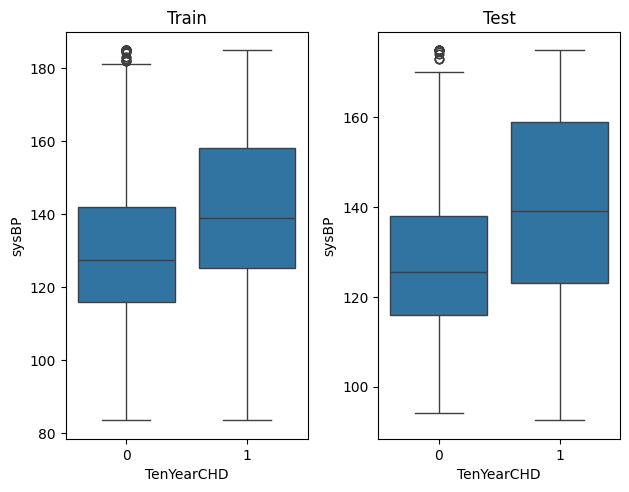

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.boxplot(data=df_train, x='TenYearCHD', y='sysBP', ax=ax[0])
sns.boxplot(data=df_test, x='TenYearCHD', y='sysBP', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 3:** Boxplots Comparing Systolic Blood Pressure and Risk of Heart Disease

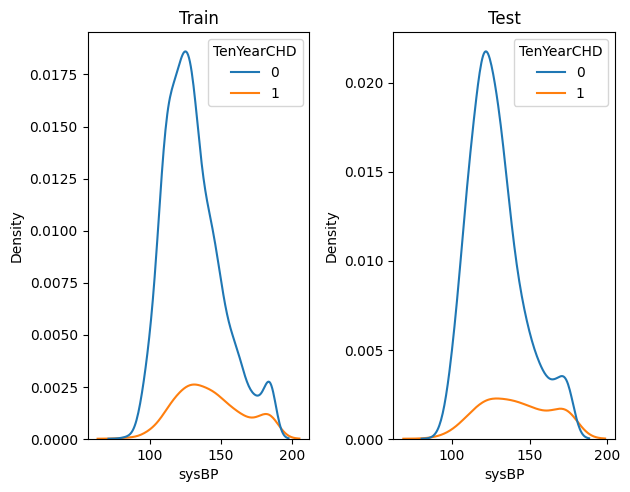

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(data=df_train, x='sysBP', hue='TenYearCHD', ax=ax[0])
sns.kdeplot(data=df_test, x='sysBP', hue='TenYearCHD', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 4:** Kernel Density Plots for Systolic Blood Pressure and Risk of Heart Disease:

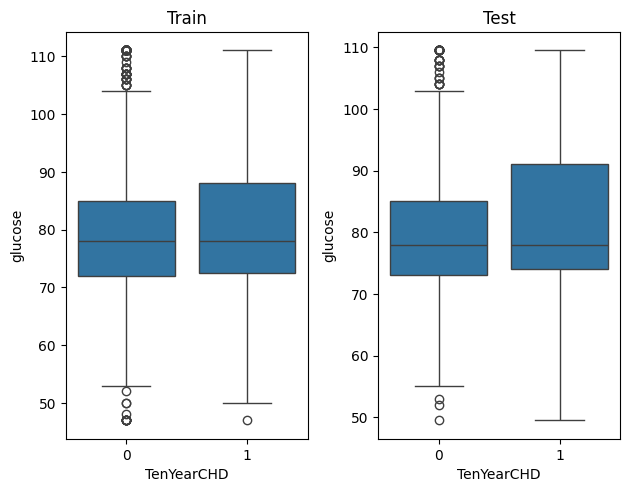

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.boxplot(data=df_train, x='TenYearCHD', y='glucose', ax=ax[0])
sns.boxplot(data=df_test, x='TenYearCHD', y='glucose', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 5:** Boxplots Comparing Glucose Levels and Risk of Heart Disease

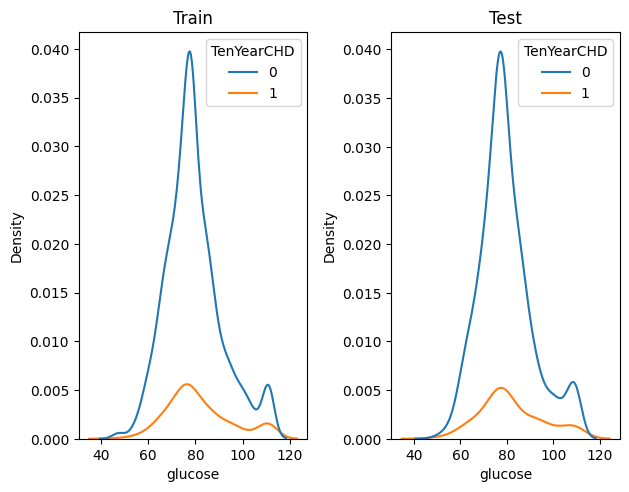

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(data=df_train, x='glucose', hue='TenYearCHD', ax=ax[0])
sns.kdeplot(data=df_test, x='glucose', hue='TenYearCHD', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 6:** Kernel Density Plots for Glucose Levels and Risk of Heart Disease

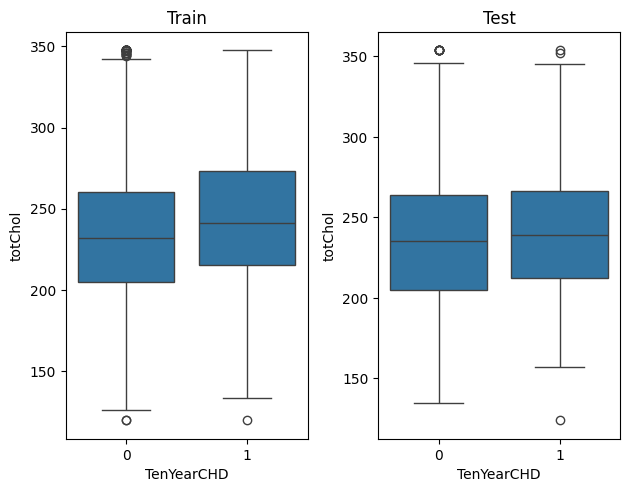

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.boxplot(data=df_train, x='TenYearCHD', y='totChol', ax=ax[0])
sns.boxplot(data=df_test, x='TenYearCHD', y='totChol', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 7:** Boxplots Comparing Total Cholesterol and Risk of Heart Disease

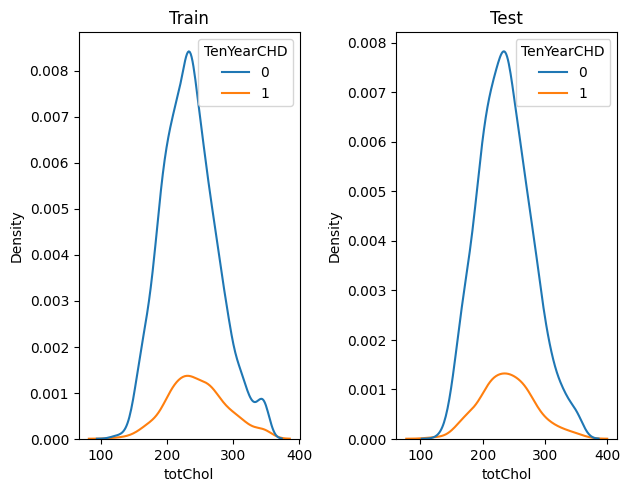

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(data=df_train, x='totChol', hue='TenYearCHD', ax=ax[0])
sns.kdeplot(data=df_test, x='totChol', hue='TenYearCHD', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 8:** Kernel Density Plots for Total Cholesterol and Risk of Heart Disease

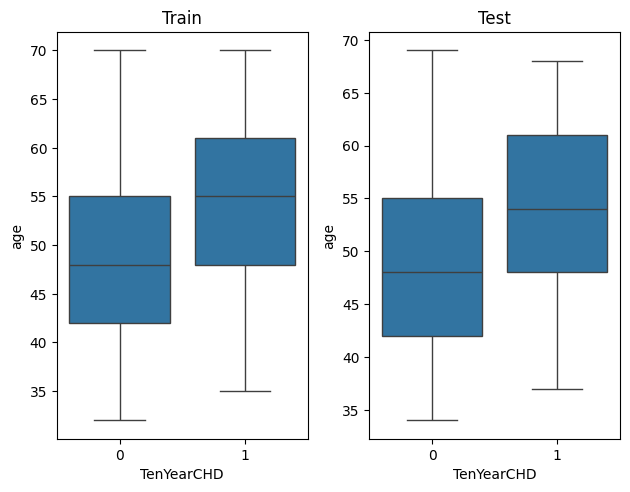

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.boxplot(data=df_train, x='TenYearCHD', y='age', ax=ax[0])
sns.boxplot(data=df_test, x='TenYearCHD', y='age', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 9:** Boxplots Comparing Age and Risk of Heart Disease

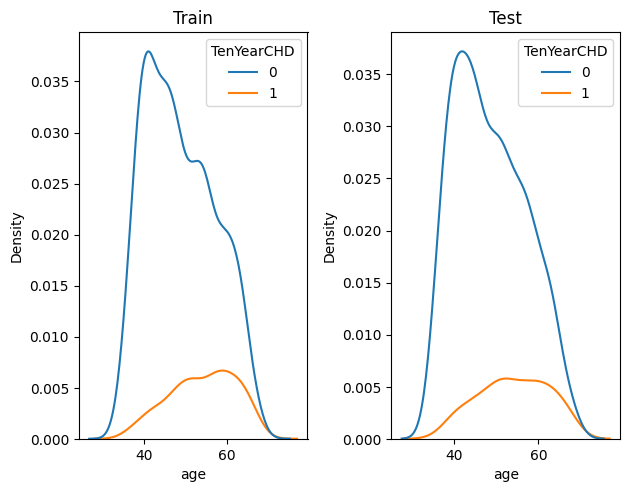

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(data=df_train, x='age', hue='TenYearCHD', ax=ax[0])
sns.kdeplot(data=df_test, x='age', hue='TenYearCHD', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 10:** Kernel Density Plots for Age and Risk of Heart Disease

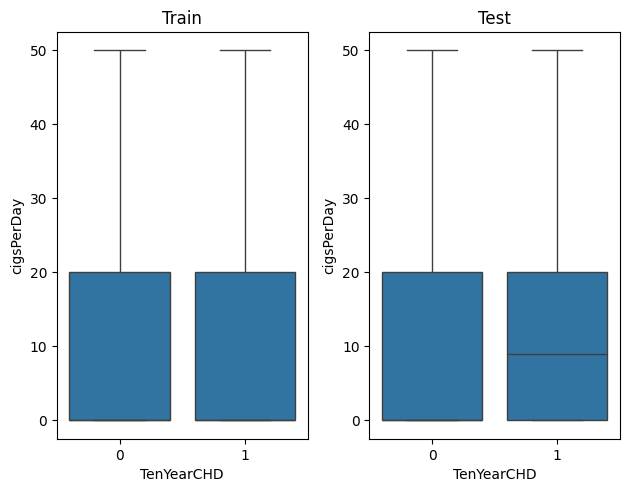

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.boxplot(data=df_train, x='TenYearCHD', y='cigsPerDay', ax=ax[0])
sns.boxplot(data=df_test, x='TenYearCHD', y='cigsPerDay', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 11:** Boxplots Comparing Number of Cigarettes Smoked Daily and Risk of Heart Disease

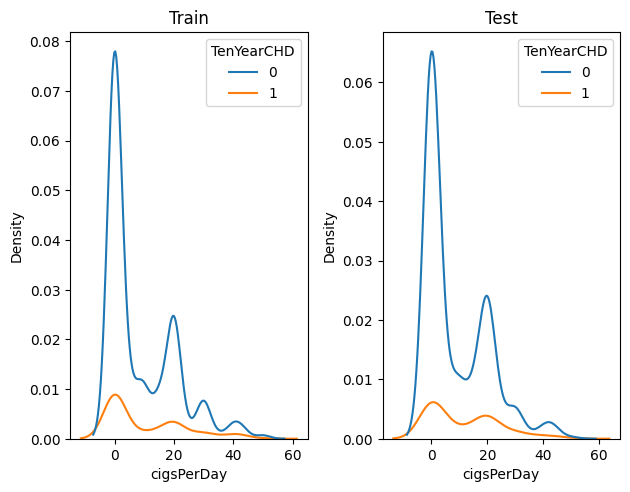

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.kdeplot(data=df_train, x='cigsPerDay', hue='TenYearCHD', ax=ax[0])
sns.kdeplot(data=df_test, x='cigsPerDay', hue='TenYearCHD', ax=ax[1])

fig.tight_layout()
ax[0].title.set_text('Train')
ax[1].title.set_text('Test')

**Figure 12:** Kernel Density Plots for Number of Cigarettes Smoked Daily and Risk of Heart Disease

In [ ]:
# Train-test split:
X_train = df_train_scale.loc[:, feature_list]
X_test = df_test_scale.loc[:, feature_list]
y_train = df_train_scale['TenYearCHD']
y_test = df_test_scale['TenYearCHD']

# Resample train split to have equal proportions of chd and non-chd
ros = RandomOverSampler(sampling_strategy='auto', random_state=0)
X_train_sampled, y_train_sampled = ros.fit_resample(X_train, y_train)

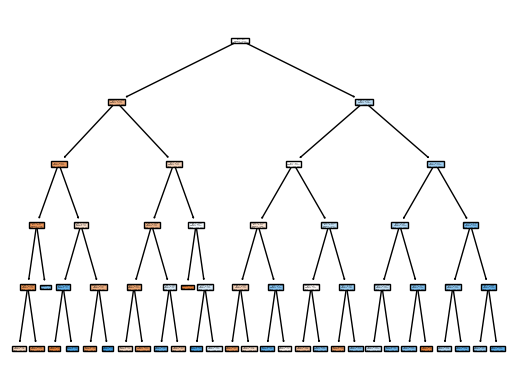

In [ ]:
# Fit decision tree:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
tree = tree.fit(X_train_sampled, y_train_sampled)

# Visualize results:
plot_tree(tree, filled=True, feature_names=tree.feature_names_in_)
plt.show()

y_hat = tree.predict(X_test) # predict for test set

**Figure 13:** Decision Tree Model

              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74       903
         1.0       0.24      0.68      0.35       157

    accuracy                           0.63      1060
   macro avg       0.58      0.65      0.55      1060
weighted avg       0.82      0.63      0.68      1060



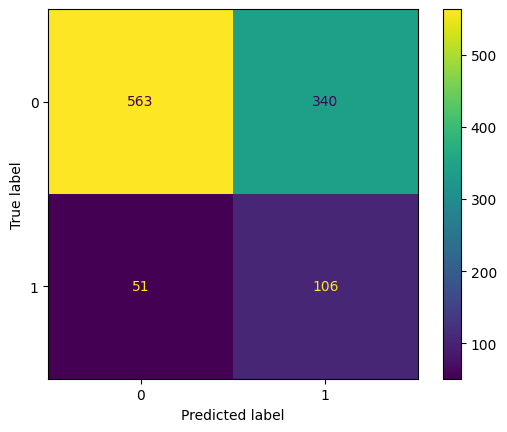

In [ ]:
# Model evaluation:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
cm.plot()

print(classification_report(y_test, y_hat))

**Figure 14:** Metrics and Confusion Matrix for Decision Tree Model

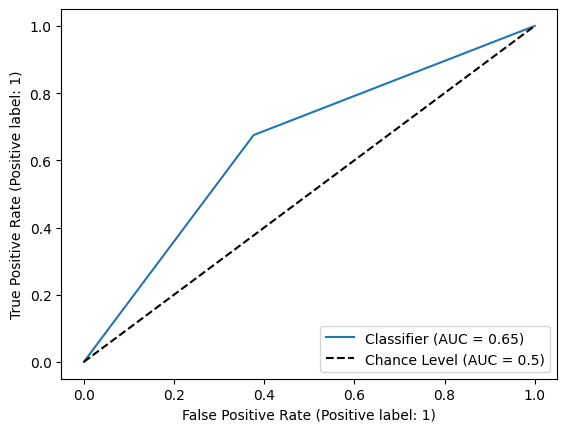

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance Level (AUC = 0.5)')
plt.legend(loc='lower right')

**Figure 15:** True Positive Rate vs False Positive Rate for Decision Tree Model

## Conclusion

> Upon analyzing the results of the confusion matrix and roc curve, it is clear that with the right predictors and dataset, it is possible to construct a reliable model that accurately forecasts whether someone is at risk for CHD in ten years. Since the group was able to create this reliable model while limiting the effects of misclassifications, the research strategy was mostly successful in answering our question. Despite having a decent number of false positives, the accuracy wasn’t too bad, and the AUC of 0.65 was pretty good for a basic classification model.

> Furthermore, as stated in the Results section, evaluating `sysBP`, `glucose`, `totChol`, `age`, and `cigsPerDay` against `TenYearCHD` allowed the decision tree to do better than random chance at predicting whether or not someone was at risk for heart disease. Combining the model results with the various visualizations reveals a clear trend where increases in factors such as `age` and `sysBP` can increase the likelihood that someone is at risk for CHD in ten years.

> While some may criticize these findings, the data and decision tree model support our assertions regarding which predictors can be used to create a reliable model to forecast the risk of CHD. As seen in the numerous boxplots within the Results section, there are clear correlations between increases in sysBP and age and the likelihood of risk of CHD. Both `sysBP` and `age` had higher median values when the participant was at risk. The data accurately depicts these findings since the group made sure to characterize and limit the effect of any outliers across the variables. The data was also imputed, winsorized, and scaled to limit the effect of missings and make analysis easier. The group's findings are also sound because no bias was applied to the results. The data came from the reputable Framingham Heart Study and we simply did some cleaning, visualizations, and basic machine learning to help answer the research question. The methodology we used to create our predictive model also aligns with our research question. A decision tree classifier was chosen because our target variable was a binary 0 or 1 for risk of heart disease and decision trees work well with nonlinear classification problems. The group also opted for an iterative approach of testing numerous hyperparameters and classification algorithms to ensure that all bases were covered when deciding on the final approach. We limited any preconceived notions about what would work best in this scenario by just testing which combinations increased the AUC score and not deciding on what model to use until we had exhausted our options.

> Moving forward, future research endeavors could explore more advanced modeling approaches, such as ensemble methods or deep learning algorithms, to enhance the accuracy and robustness of CHD prediction models. Additionally, efforts to enrich the dataset with additional variables or incorporate more recent data sources may yield insights that contribute to more effective risk prediction and ultimately improve the prevention and management of CHD.

> Our findings highlight a multitude of conditions that can affect the risk of heart disease and the ways in which it can be predicted. While insights were made, further research is essential to gain an even more comprehensive understanding of coronary heart disease and its causative factors.


#### Reference
*All data for this project was derived from the Framingham Heart Study, which is available in our repository and at https://www.framinghamheartstudy.org/*